In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
import scoping.models as sm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

In [15]:
#runs = tm.RunStats.objects.filter(psearch__id=63, method='BD', alpha=0.01, top_chain_var=0.005).order_by('K')
#runs = tm.RunStats.objects.filter(psearch__id=63, method='BD', K=40, alpha=0.01, status=3).order_by('top_chain_var')
runs = tm.RunStats.objects.filter(psearch__id=63, method='BD', K=40, top_chain_var=0.005, status=3).order_by('alpha')


run_ids = [run.run_id for run in runs]
print(run_ids)
print("K: {}".format([run.K for run in runs]))
print("alpha: {}".format([run.alpha for run in runs]))
print("top_chain_var: {}".format([run.top_chain_var for run in runs]))
print("status: {}".format([run.status for run in runs]))


[1900, 2097, 2096, 2095]
K: [40, 40, 40, 40]
alpha: [0.01, 0.1, 0.5, 1.0]
top_chain_var: [0.005, 0.005, 0.005, 0.005]
status: [3, 3, 3, 3]


In [16]:
#run_ids = [1898, 1916, 1905, 1907, 1900, 2043, 2044] # runs with standard settings and K variation
#run_ids = [1902, 1905, 1899, 1901, 1915] # variation of alpha

#run_ids = [1979, 1977, 2094, 1980, 2093, 1981] # variation of alpha with pars
#run_ids = [1979, 1977, 1980, 1981]

#run_ids = [1900, 2101, 2100, 2099] # variation of top_chain_var
#runs = tm.RunStats.objects.filter(pk__in=run_ids).order_by('top_chain_var')

method = "BD"
search_name = "kohle"
topics = []
Ks = []

for run_id in run_ids:
    for topic in tm.Topic.objects.filter(run_id=run_id):
        if topic.top_words:
            print('top words: {}'.format(topic.top_words))
        else:
            terms = tm.Term.objects.filter(topicterm__topic=topic).values('title').annotate(
                        summed_score = Sum(F('topicterm__score'))).order_by('-summed_score')[:20]
            term_list = [t['title'] for t in terms]
            topic.top_words = term_list
            topic.save()

            print('assigned new top words: {}'.format(topic.top_words))
            
    topics.append(tm.Topic.objects.filter(run_id=run_id).order_by('-score'))
    stat = tm.RunStats.objects.get(run_id=run_id)
    Ks.append(stat.K)


top words: ['haushalt', 'million', 'haushaltsausschuss', 'einzelplan', 'mittel', 'bereich', 'forder', 'programm', 'kurzung', 'geld', 'ansatz', 'etat', 'milliard', 'minist', 'stell', 'mittelstand', 'ministerium', 'klein', 'verfug', 'titel']
top words: ['subvention', 'wettbewerb', 'abbau', 'kartell', 'subventionsabbau', 'arbeitsplatz', 'subventionier', 'bereich', 'subventioniert', 'steinkohl', 'ordnungspolit', 'steuerzahl', 'sozialvertrag', 'erhalt', 'klar', 'fdp', 'steinkohlesubvention', 'glos', 'mull', 'rag']
top words: ['saar', 'saarland', 'nordrheinwestfal', 'arbeitsplatz', 'region', 'bundesregier', 'regional', 'strukturpolit', 'strukturwandel', 'stahlindustri', 'zonenrandgebiet', 'landesregier', 'ruhrgebiet', 'bund', 'kohl', 'stahl', 'gebiet', 'betroff', 'stadt', 'unternehm']
top words: ['wirtschaftspolit', 'wachstum', 'wirtschaft', 'marktwirtschaft', 'bundesregier', 'jahreswirtschaftsbericht', 'konjunkturpolit', 'sachverstandigenrat', 'stabilitat', 'offent', 'unternehm', 'bundesban

In [6]:
#save_topic_list_as_table(topics[0], "topic_list_{}_{}_K{}_tei.csv".format(search_name, method, Ks[0]))

In [17]:
Ks

[40, 40, 40, 40]

In [18]:
#Top Word Overlap comparison method
% matplotlib inline

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/muef/coal-discourse/topic_comparison"}
save_res(runs, [res_tw,ss], options)

['run_2097_topics_40', 'scores_2097', 'similarity_2097-2095', 'run_2095_topics_40', 'scores_2095', 'similarity_2095-2096', 'run_2096_topics_40', 'scores_2096', 'similarity_2096-1900', 'run_1900_topics_40', 'scores_1900']
C2:C55
F2:F55
I2:I55


0

matching sum:	266.0
max rows:	278.0
max cols:	281.0


0

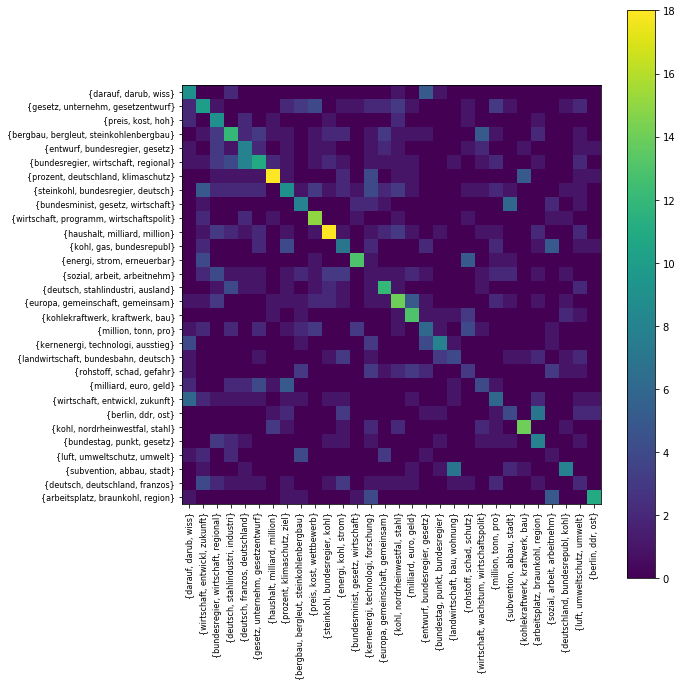

In [18]:
#draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics[0], topics[1], match=True, filename="topword_score_matrix_{}_{}_K{}_K{}.png".format(search_name, method, Ks[0], Ks[1]))

['run_1969_topics_30', 'scores_1969', 'similarity_1969-1970', 'run_1970_topics_40', 'scores_1970']
matching sum:	8.687220493819662
max rows:	9.519335522177242
max cols:	9.686449025598302


0

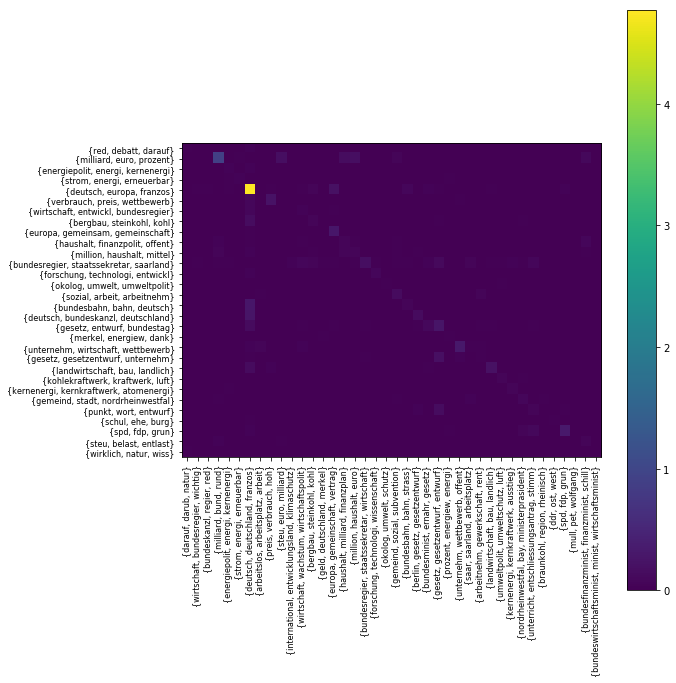

In [13]:
#Score Product comparison method
res, ss, score_prod_matrix = compare_topic_queryset(runs, method="score_product", order_by_str='-score')

#draw_score_matrix(score_prod_matrix, topics1, topics2, match=True, filename="prod_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_prod_matrix, topics[0], topics[1], match=True, filename="prod_score_matrix_{}_{}_K{}_K{}.png".format(search_name, method, Ks[0], Ks[1]))

In [16]:
matrix1, permutation1 = sort_matrix(score_matrix)
matrix2, permutation2 = sort_matrix(score_prod_matrix)

sum(permutation1 == permutation2)

matching sum:	152.0
max rows:	152.0
max cols:	185.0
matching sum:	102.15815595566878
max rows:	102.15815595566879
max cols:	125.40763883634058


11

In [17]:
from termcolor import colored

def print_topics(topics1, topics2):
    
    for i in range(len(topics1)):
        sim_score = len(set(topics1[i].top_words).intersection(set(topics2[i].top_words)))

        if topics1[i].top_words == topics2[i].top_words:
            print("#{}: score: {}, matching".format(i, sim_score))
        elif sim_score > 5:
            print("#{}: score: {}, not matching".format(i, sim_score))
        else:
            print(colored("#{}: score: {}, not matching".format(i, sim_score), 'red'))

        print("{}\n{}".format(", ".join(topics1[i].top_words), ", ".join(topics2[i].top_words)))

matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	152.0
max rows:	152.0
max cols:	185.0
#0: score: 2, not matching
jahr, antrag, heut, seit, land, unternehm, gross, mensch, mehr, schon
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#1: score: 0, not matching
sag, ganz, geht, gesagt, imm, klar, red, thema, tun, nordrheinwestfal
jahr, letzt, seit, zehn, heut, deutsch, pro, lang, bundesregier, word
#2: score: 0, not matching
energi, erneuerbar, ausbau, strom, fossil, kernenergi, energiew, anteil, energiepolit, eeg
mensch, land, wald, region, rohstoff, nachhalt, betroff, heut, verantwort, leb
#3: score: 0, not matching
kohl, gas, aussteig, kernenergi, ausstieg, grun, energietrag, verbrenn, bleib, erdgas
herr, dam, prasident, geehrt, verehrt, minist, gabriel, gesagt, heut, herrn
#4: score: 0, not matching
deutschland, technologi, land, china, weltweit, ccs, kohleverstrom, welt, international, deutsch
sag, ganz, klar, red, imm, tun, thema, kohlesubvention, mocht, stell
#5: score: 0, not matching
kohlekr

In [18]:
matrix = score_matrix
if sum([row.max() for row in matrix]) > sum([col.max() for col in matrix.T]):
    permutation = [row.argmax() for row in matrix]
else:
    permutation = [col.argmax() for col in matrix.T]

topic_list2 = [topics2[int(permutation[i])] for i in range(K)]

print_topics(topics1, topic_list2)

#0: score: 2, not matching
jahr, antrag, heut, seit, land, unternehm, gross, mensch, mehr, schon
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#1: score: 0, not matching
sag, ganz, geht, gesagt, imm, klar, red, thema, tun, nordrheinwestfal
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#2: score: 0, not matching
herr, kolleg, dam, lieb, kolleginn, frau, geehrt, prasident, prasidentin, verehrt
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#3: score: 0, not matching
energi, erneuerbar, ausbau, strom, fossil, kernenergi, energiew, anteil, energiepolit, eeg
mensch, land, wald, region, rohstoff, nachhalt, betroff, heut, verantwort, leb
#4: score: 0, not matching
kohl, gas, aussteig, kernenergi, ausstieg, grun, energietrag, verbrenn, bleib, erdgas
jahr, letzt, seit, zehn, heut, deutsch, pro, lang, bundesregier, word
#5: score: 0, not matching
deutschland, technologi, land, china, weltweit, ccs, kohleverstrom, welt, int

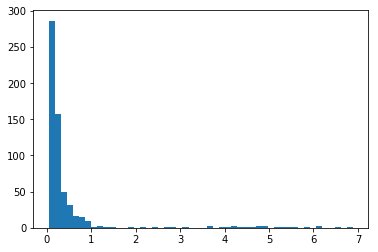

In [27]:
fig = plt.hist(score_prod_matrix.flatten(), bins=50)

In [14]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K{}_topword_score'.format(search_name, method, Ks[0], Ks[1]))

matching sum:	363.0
max rows:	370.0
max cols:	422.0


NameError: name 'K1' is not defined

In [ ]:
matrix1, permutation1 = sort_matrix(score_prod_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix1, threshold=1.5)
perm_topic_list = [topics1[int(permutation1[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename="bipartite_topic_graph_{}_{}_K{}_prod_score".format(search_word, method, K))

In [ ]:
matrix1, permutation1 = sort_matrix(score_prod_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(score_prod_matrix, threshold=1.5)
draw_bipartite_topic_graph(g, topics1, topics2, "bipartite_topic_graph_K{}_prod_score_not_sorted".format(K))